# Fully Autonomous Line-Follower Drone
This project was realized for the [REDS institute](https://reds.heig-vd.ch/) @ [HEIG-VD](https://heig-vd.ch/).

Authors: Guillaume Chacun, Mehdi Akeddar, Thomas Rieder, Bruno Da Rocha Carvalho and Marina Zapater<br>
REDS. School of Engineering and Management Vaud, HES-SO University of Applied sciences and Arts Western Switzerland<br>
Email: {guillaume.chacun, mehdi.akeddar, thomas.rieder, bruno.darochacarvalho, marina.zapater}@heig-vd.ch<br>

## Goal
This Jupyter notebook is used to train a DDPG (reinforcement learning) model to control a drone, specifically to guide it to follow a predefined line on the ground. A separate deep learning model is used to identify and track the line from images captured by the on-board camera. The pilot module processes real-world normalised coordinates of points A and B (see image below) and generates forward, lateral and angular velocities for the drone.

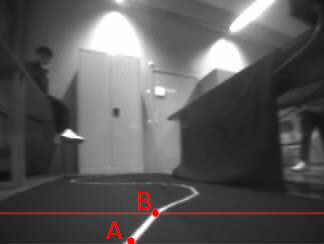

## Content of this repository
- This Notebook is used to train the reinforcement learning model.
- *ddpg_torch.py* : DDPG related classes (OUActionNoise, ReplayBuffer, CriticNetwork, ActorNetwork, Agent).
- *Drone.py* : Class to simulate the behavior of the drone.
- *Line.py* : Class to generate a random line for the drone to follow.
- *Environment.py* : Class to handle the simulation (episodes). Contains an instance of Drone and Line.

## Setup
Install dependencies:

```bash
poetry install
```

Activate the virtual environment of Poetry:
```bash
poetry shell
```

Start your Jupyter Lab server:
```bash
jupyter lab
```

## Disclaimer
Most of the DDPG code is from [@philtabor's GitHub](https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/DDPG/pytorch/lunar-lander/ddpg_torch.py) (last visited on March 5th, 2024).

# Imports

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from multiprocessing import Process, Event
import neptune
import numpy as np
from tqdm import tqdm # does not work with tqdm.notebook
import yaml

In [2]:
%matplotlib inline
# does not work with %matplotlib widgets

In [3]:
%load_ext autoreload
%autoreload 2
from ddpg_torch import Agent
from Drone import Drone
from Environment import Environment

# Parameters

In [4]:
log = True

In [5]:
load_weights = False

In [6]:
seed = 23
np.random.seed(seed)

In [7]:
# DPPG parameters
alpha = 0.000025
beta = 0.00025
tau = 0.001
batch_size = 128
layer1_size = 400
layer2_size = 300
memory_size = 0 # size of 0 disables the agent's memory

In [8]:
# Environment parameters
max_allowed_dist = 0.15 # from the drone to the nearest point on the line (meters)
# reward
speed_z_activation_dist = 5
target_dist_p1_C = .15
alpha = .75
beta = 3
gamma = 2

In [9]:
# Drone parameters
allow_x_movement = False
z_min_speed = .05        # meters / second
z_max_speed = .40       # meters / second
x_max_speed = .01        # meters / second
max_angular_speed = 25. # degrees / seconds
max_drift = 0.          # meters

In [10]:
state_dims = 3
n_actions = 3 if allow_x_movement else 2

# Setup

In [11]:
# load neptune api key
with open('.neptune_config.yaml', 'r') as config_file:
    neptune_config = yaml.safe_load(config_file)
api_token = neptune_config.get('api_token')

In [12]:
if log:
    # init neptune
    run = neptune.init_run(
        project='chacungu/Drone-Controller-with-Reinforcement-Learning', 
        api_token=api_token, 
        tags=['reds'],
        capture_stdout=False,
        capture_stderr=False,
        capture_traceback=False,
        capture_hardware_metrics=False,
    )
    run['parameters'] = {
        'Model/state_dims': state_dims,
        'Model/n_actions': n_actions,
        
        'Model/alpha': alpha,
        'Model/beta': beta,
        'Model/tau': tau,
        'Model/batch_size': batch_size,
        'Model/layer1_size': layer1_size,
        'Model/layer2_size': layer2_size,
        'Model/memory_size': memory_size,
        
        'Environment/max_allowed_dist': max_allowed_dist,
        'Environment/max_drift': max_drift,
        
        'Reward/speed_z_activation_dist': speed_z_activation_dist,
        'Reward/target_dist_p1_C': target_dist_p1_C,
        'Reward/alpha': alpha,
        'Reward/beta': beta,
        'Reward/gamma': gamma,

        'Pilot/allow_x_movement': allow_x_movement,
        'Pilot/z_min_speed': z_min_speed,
        'Pilot/z_max_speed': z_max_speed,
        'Pilot/x_max_speed': x_max_speed,
        'Pilot/max_angular_speed': max_angular_speed,
        
        'Drone/height': Drone._height,
        'Drone/fps': Drone._fps,
        'Drone/flight_commands_rate': Drone._flight_commands_rate,
    }

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/chacungu/Drone-Controller-with-Reinforcement-Learning/e/RLCONTROL-39


In [13]:
# GUI Toggle Button
def toggle_render_event(change):
    if change.new:
        is_toggle_render.set()
    else:
        is_toggle_render.clear()
    clear_output(wait=True)

is_toggle_render = Event() # shared value storing the state of the Toggle Button
toggle_render = widgets.ToggleButton(value=False, description='Toggle Render')
toggle_render.observe(toggle_render_event, 'value')

In [14]:
# GUI Output area
out = widgets.Output(layout={'border': '1px solid black'})

In [15]:
# Training Loop
def run_loop(toggle_render, out, pbar, n_episodes, load_weights):
    # init 
    env = Environment(seed, max_allowed_dist, z_min_speed, z_max_speed, x_max_speed, max_angular_speed, max_drift,
                      allow_x_movement, speed_z_activation_dist, target_dist_p1_C, alpha, beta, gamma)
    agent = Agent(alpha=alpha, beta=beta, input_dims=[state_dims + state_dims*memory_size], n_actions=n_actions, tau=tau,
                  batch_size=batch_size, layer1_size=layer1_size, layer2_size=layer2_size, memory_size=memory_size, 
                  allow_x_movement=allow_x_movement)
    if load_weights:
        agent.load_models()
    score_history = []
    speed_z_history = []
    speed_x_history = []
    speed_a_history = []
    
    for i in range(n_episodes):
        agent.reset_states_memory()
        state = env.reset()
        done = False
        score = 0
        
        episode_history = {
            'speed_z': [],
            'speed_x': [],
            'speed_a': [],
        }
        
        while not done: # while episode is not over
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated = env.step(action)
            done = terminated or truncated
            agent.remember(state, action, reward, new_state, int(done))
            agent.learn()
            score += reward
            state = new_state

            # save speeds
            if not allow_x_movement:
                action = [action[0], 0., action[1]]
            speed_z, speed_x, speed_a = env.drone.pilot_speeds_to_drones(*action)
            episode_history['speed_z'].append(speed_z)
            episode_history['speed_x'].append(speed_x)
            episode_history['speed_a'].append(speed_a)
            
            if is_toggle_render.is_set():
                env.render(out)

        # save score & speeds
        score_history.append(score)
        avg_speed_z = np.mean(episode_history['speed_z'])
        speed_z_history.append(avg_speed_z)
        avg_speed_x = np.mean(episode_history['speed_x'])
        speed_x_history.append(avg_speed_x)
        avg_speed_a = np.mean(episode_history['speed_a'])
        speed_a_history.append(avg_speed_a)
        if log:
            run['train/reward'].log(score)
            run['train/avg_speed_z'].log(avg_speed_z)
            run['train/avg_speed_x'].log(avg_speed_x)
            run['train/avg_speed_a'].log(avg_speed_a)

        # update progress bar
        pbar.update(1)
        pbar.set_description(
            'avg score %.3f | avg z %.2f | avg x %.2f | avg a %.1f' % (
                np.mean(score_history[-100:]),
                np.mean(speed_z_history[-100:]),
                np.mean(speed_x_history[-100:]),
                np.mean(speed_a_history[-100:]),
        ))

        # save models
        if i % 100 == 0:
            agent.save_models()

# Training

In [16]:
# Display the toggle button and the plot area
display(toggle_render, out)

# Display the progress bar
n_episodes = int(1e7)
pbar = tqdm(total=n_episodes, position=0)

# Start the process that handles the training
process = Process(target=run_loop, args=(toggle_render, out, pbar, n_episodes, load_weights))
process.start()

ToggleButton(value=False, description='Toggle Render')

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

avg score 1.450 | avg z 0.39 | avg x 0.00 | avg a 25.0:   0%|          | 685/10000000 [02:54<798:16:55,  3.48it/s] 

In [17]:
# interrupt the training
#process.join()

In [18]:
if log:
    # stop neptune
    run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/chacungu/Drone-Controller-with-Reinforcement-Learning/e/RLCONTROL-32/metadata


# Tests

## Reward func

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

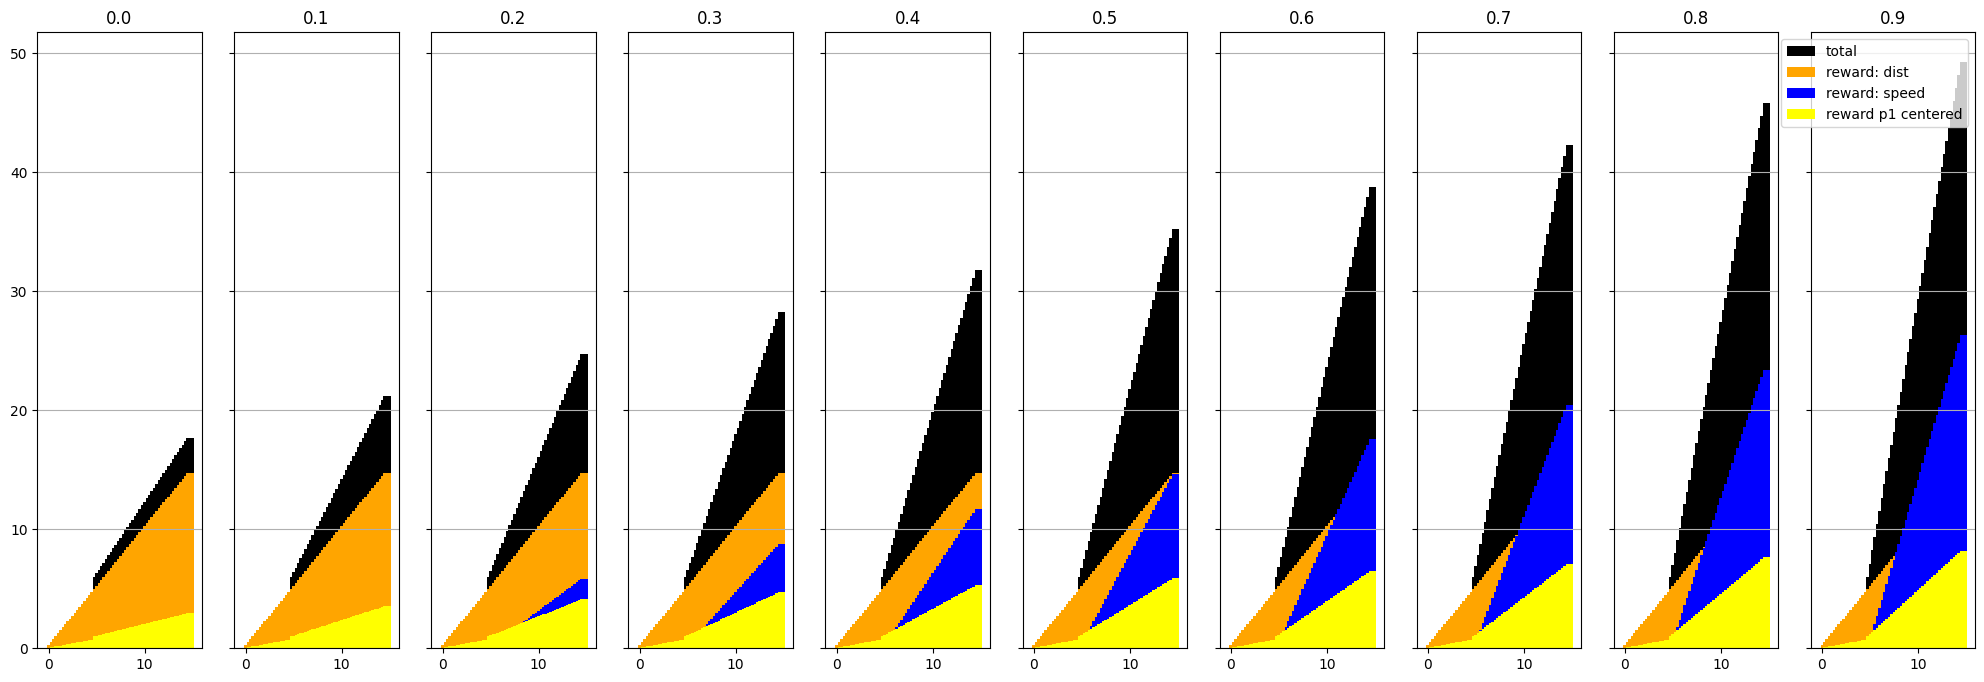

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_reward_(travelled_distance, dist_p1_C, 
                speed_z, speed_z_activation_dist=5, target_dist_p1_C=.15, 
                alpha=.75, beta=3, gamma=2):
    # speed_z in range [ 0., 1.]
    # dist_p1_C in range [-1., 1.]
    reward_A = travelled_distance * (alpha if travelled_distance < speed_z_activation_dist else 1.)
    reward_B = max(0, travelled_distance - speed_z_activation_dist) * beta * speed_z
    reward_C = (reward_A + reward_B) * np.interp(dist_p1_C, [ 0., 1.], [0.1, 1.]) * gamma
    return reward_A, reward_B, reward_C
    
fig, axes = plt.subplots(1,10, figsize=(25,8), sharey=True)
dists = np.arange(0.,15., .25)
for ax, speed in zip(axes, np.arange(0., 1.11, .1)):
    ax.set_title('%.1f' % speed)
    rewards = list(map(lambda d: get_reward_(d, 0, speed), dists))
    ax.bar(dists, list(map(sum, rewards)), color='black', label='total')
    ax.bar(dists, dists, color='orange', label='reward: dist')
    ax.bar(dists, list(map(lambda r: r[1], rewards)), color='blue', label='reward: speed')
    ax.bar(dists, list(map(lambda r: r[2], rewards)), color='yellow', label='reward p1 centered')
    ax.grid(axis='y')
    plt.legend(loc='best')

## Environment

In [ ]:
testenv = Environment(seed=23)
testout = widgets.Output(layout={'border': '1px solid black'})

In [ ]:
testenv.step([0, 
              0, 
              0])

In [ ]:
testfig, testax = plt.subplots(figsize=(12, 8))
display(testout)
testenv.render(testout)

## Exploring ideas...

- remove x movement from model (not just setting x_max_speed to 0)
  - currently trying this but also slightly reducing importance of speed in reward and reducing max_angle_speed
- what if we "mapped" the line? the drone would see the line and store the coordinates of both points. we would also try to calculate the coordinates of the drone in the scene. then we would calculate the nearest point on the mapped line from the drone and feed the model with this point and the N future ones along with the position of the drone. the hope would be that the model learns to correct the current drone trajectory to stick to the line but also try to predict the future events.